# 📚 Import Required Libraries

In [ ]:
import os
import copy
import torch
import pickle
import pathlib
import logging
import numpy as np
import torchvision
import torch.nn as nn
from tqdm.auto import tqdm
from itertools import cycle
import torch.optim as optim
from google.colab import files
from google.colab import drive
import torch.nn.functional as F
from types import SimpleNamespace
from IPython.display import display
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from PIL import Image, ImageDraw, ImageFont
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid

# 🚀 train a conditional VAE on all 10 MNIST classes.

## Mount Google Drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


## Configuration

In [ ]:
# create a main project folder in Google Drive
gdrive_project_folder = "/content/drive/MyDrive/Colab_Selective_Amnesia"
output_folder_in_drive = os.path.join(gdrive_project_folder, "cvae_mnist_output")
os.makedirs(output_folder_in_drive, exist_ok=True)

config = SimpleNamespace(
    # Training parameters
    data_path="./dataset",
    batch_size=256,
    n_iters=100000, # The paper uses 100k iterations
    log_freq=5000,
    n_vis_samples=100,
    lr=0.0001,

    # Model parameters
    dataset="MNIST",
    x_dim=784,
    h_dim1=512,
    h_dim2=256,
    z_dim=8,

    output_dir=output_folder_in_drive,
)

# Create directories for logs and checkpoints
config.log_dir = os.path.join(config.output_dir, "logs")
config.ckpt_dir = os.path.join(config.output_dir, "checkpoints")
os.makedirs(config.log_dir, exist_ok=True)
os.makedirs(config.ckpt_dir, exist_ok=True)

## Logging Setup

In [ ]:
handler = logging.StreamHandler()
formatter = logging.Formatter("%(levelname)s - %(asctime)s - %(message)s")
handler.setFormatter(formatter)
logger = logging.getLogger()
if logger.hasHandlers():
    logger.handlers.clear()
logger.addHandler(handler)
logger.setLevel(logging.INFO)

## Model

In [ ]:
class OneHotCVAE(nn.Module):
    """
    Conditional VAE with one-hot encoding for the condition.
    """
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim, class_size=10):
        super(OneHotCVAE, self).__init__()

        # Encoder
        self.fc1 = nn.Linear(x_dim + class_size, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)

        # Decoder
        self.fc4 = nn.Linear(z_dim + class_size, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)

    def encoder(self, x, c):
        inputs = torch.cat([x, c], dim=1)
        h = F.relu(self.fc1(inputs))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h)

    def sampling(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # reparameterization trick

    def decoder(self, z, c):
        inputs = torch.cat([z, c], dim=1)
        h = F.relu(self.fc4(inputs))
        h = F.relu(self.fc5(h))
        return torch.sigmoid(self.fc6(h))

    def forward(self, x, c):
        mu, log_var = self.encoder(x.view(-1, config.x_dim), c)
        z = self.sampling(mu, log_var)
        recon_x = self.decoder(z, c)
        return recon_x, mu, log_var

## Loss Function Definitions

In [ ]:
def loss_function(recon_x, x, mu, log_var):
    """
    Calculates the VAE loss
    """
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, config.x_dim), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

## Training, Testing, and Sampling Functions

In [ ]:
def train():
    """The main training loop."""

    vae.train()
    train_loss = 0

    logging.info("Starting training...")

    for step in range(1, config.n_iters + 1):
        data, label = next(train_iter)
        label_one_hot = F.one_hot(label, 10).float()

        data = data.to(device)
        label_one_hot = label_one_hot.to(device)

        optimizer.zero_grad()
        recon_batch, mu, log_var = vae(data, label_one_hot)
        loss = loss_function(recon_batch, data, mu, log_var)

        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        if step % config.log_freq == 0:
            avg_train_loss = train_loss / (config.log_freq * config.batch_size)
            avg_test_loss = test()
            logging.info(f'Train Step: {step}/{config.n_iters} ({100. * step / config.n_iters:.0f}%)\t'
                         f'Avg Train Loss: {avg_train_loss:.4f}\t'
                         f'Avg Test Loss: {avg_test_loss:.4f}')
            sample(step)
            train_loss = 0
            vae.train() # Set back to training mode after sampling/testing

def test():
    """Evaluates the model on the test dataset."""

    vae.eval()
    test_loss = 0

    with torch.no_grad():
        for data, label in test_loader:
            label_one_hot = F.one_hot(label, 10).float()
            data = data.to(device)
            label_one_hot = label_one_hot.to(device)
            recon, mu, log_var = vae(data, label_one_hot)
            test_loss += loss_function(recon, data, mu, log_var).item()

    avg_test_loss = test_loss / len(test_loader.dataset)
    return avg_test_loss

def sample(step):
    """Generates and saves a grid of images from the model."""

    vae.eval()

    with torch.no_grad():
        # Create a fixed noise vector and labels for consistent visualization
        z = torch.randn((config.n_vis_samples, config.z_dim)).to(device)
        c_labels = torch.arange(10).repeat_interleave(config.n_vis_samples // 10)
        c_one_hot = F.one_hot(c_labels, 10).float().to(device)

        out = vae.decoder(z, c_one_hot).view(-1, 1, 28, 28)

        grid = make_grid(out, nrow=config.n_vis_samples // 10)
        save_path = os.path.join(config.log_dir, f"sample_step_{step}.png")
        save_image(grid, save_path)
        logging.info(f"Saved sample image to {save_path}")

## Main Execution

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logging.info(f"Using device: {device}")

# Load MNIST
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root=config.data_path, train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root=config.data_path, train=False, transform=transform, download=True)

# Create Data Loaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=config.batch_size, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=config.batch_size, shuffle=False)

# create an infinite iterator over the training data
train_iter = cycle(train_loader)

# Build Model
vae = OneHotCVAE(x_dim=config.x_dim, h_dim1=config.h_dim1, h_dim2=config.h_dim2, z_dim=config.z_dim).to(device)

optimizer = optim.Adam(vae.parameters(), lr=config.lr)

# Start Training
train()

# Save the final model and config
final_ckpt_path = os.path.join(config.ckpt_dir, "cvae_mnist_final.pt")
torch.save({
    "model_state_dict": vae.state_dict(),
    "config": config
}, final_ckpt_path)
logging.info(f"Training complete. Final model saved to {final_ckpt_path}")

# You can uncomment the line below to automatically download the final model
# files.download(final_ckpt_path)

INFO - 2025-08-03 09:31:05,927 - Using device: cpu
INFO - 2025-08-03 09:31:06,021 - Starting training...
INFO - 2025-08-03 09:35:07,863 - Train Step: 5000/100000 (5%)	Avg Train Loss: 140.4244	Avg Test Loss: 114.4602
INFO - 2025-08-03 09:35:07,897 - Saved sample image to /content/drive/MyDrive/Colab_Selective_Amnesia/cvae_mnist_output/logs/sample_step_5000.png
INFO - 2025-08-03 09:39:00,580 - Train Step: 10000/100000 (10%)	Avg Train Loss: 110.9415	Avg Test Loss: 107.1669
INFO - 2025-08-03 09:39:00,896 - Saved sample image to /content/drive/MyDrive/Colab_Selective_Amnesia/cvae_mnist_output/logs/sample_step_10000.png
INFO - 2025-08-03 09:42:55,707 - Train Step: 15000/100000 (15%)	Avg Train Loss: 105.9545	Avg Test Loss: 104.2581
INFO - 2025-08-03 09:42:55,997 - Saved sample image to /content/drive/MyDrive/Colab_Selective_Amnesia/cvae_mnist_output/logs/sample_step_15000.png
INFO - 2025-08-03 09:46:54,774 - Train Step: 20000/100000 (20%)	Avg Train Loss: 103.2871	Avg Test Loss: 102.4340
INFO 

# 🧮 Calculate Fisher Information Matrix (FIM)

## Configuration

In [ ]:
fim_config = SimpleNamespace(

    ckpt_path=os.path.join(output_folder_in_drive, "checkpoints/cvae_mnist_final.pt"),

    n_fim_samples=50000, # Number of samples to use for FIM calculation

    batch_size=256,

    output_dir=output_folder_in_drive,
)

## FIM Calculation Function

In [ ]:
def calculate_and_save_fim(model, device, config):
    """Calculates and saves the diagonal of the Fisher Information Matrix."""

    fisher_dict = {}

    for name, param in model.named_parameters():
        if param.requires_grad:
            fisher_dict[name] = torch.zeros_like(param.data)

    # Set the model to evaluation mode for generating samples
    model.eval()

    logging.info(f"Calculating Fisher Matrix with {config.n_fim_samples} samples...")

    pbar = tqdm(total=config.n_fim_samples)

    num_processed = 0

    while num_processed < config.n_fim_samples:
        # Determine batch size for this iteration
        current_batch_size = min(config.batch_size, config.n_fim_samples - num_processed)

        # Generate a batch of samples from the model by sampling from the trained generator itself.
        with torch.no_grad():
            z = torch.randn(current_batch_size, model.fc31.out_features).to(device)
            c_labels = torch.randint(0, 10, (current_batch_size,)).to(device)
            c_one_hot = F.one_hot(c_labels, 10).float()
            generated_samples = model.decoder(z, c_one_hot)

        # Set model to train mode to enable gradient calculation and then Calculate gradients for the batch
        model.train()
        model.zero_grad()

        recon_batch, mu, log_var = model(generated_samples, c_one_hot)

        # average the loss over the batch for the backward pass
        loss = loss_function(recon_batch, generated_samples, mu, log_var) / current_batch_size
        loss.backward()

        # Accumulate the squared gradients
        for name, param in model.named_parameters():
            if param.grad is not None:
                # The multiplication by current_batch_size is to correct for the division in the loss
                fisher_dict[name] += param.grad.data.pow(2) * current_batch_size

        num_processed += current_batch_size
        pbar.update(current_batch_size)

    pbar.close()

    # Average the FIM over all samples
    for name in fisher_dict:
        fisher_dict[name] /= config.n_fim_samples

    # Save the calculated FIM
    fim_save_path = os.path.join(config.output_dir, 'fisher_dict.pkl')
    with open(fim_save_path, 'wb') as f:
        pickle.dump(fisher_dict, f)

    logging.info(f"Fisher Matrix calculation complete. Saved to {fim_save_path}")
    return fim_save_path

## Main Execution

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logging.info(f"Using device: {device}")


if not os.path.exists(fim_config.ckpt_path):
    logging.error(f"Checkpoint not found at {fim_config.ckpt_path}. Please run the first training script.")

else:
    checkpoint = torch.load(fim_config.ckpt_path, map_location=device, weights_only=False)
    config_from_ckpt = checkpoint['config']

    # Build the model using the configuration from the checkpoint
    vae = OneHotCVAE(
        x_dim=config_from_ckpt.x_dim,
        h_dim1=config_from_ckpt.h_dim1,
        h_dim2=config_from_ckpt.h_dim2,
        z_dim=config_from_ckpt.z_dim
    ).to(device)

    # Load the trained weights into the model
    vae.load_state_dict(checkpoint['model_state_dict'])
    logging.info(f"Successfully loaded pre-trained model from {fim_config.ckpt_path}")

    calculate_and_save_fim(vae, device, fim_config)

INFO - 2025-08-03 09:41:48,403 - Using device: cuda
INFO - 2025-08-03 09:41:48,427 - Successfully loaded pre-trained model from /content/drive/MyDrive/Colab_Selective_Amnesia/cvae_mnist_output/checkpoints/cvae_mnist_final.pt
INFO - 2025-08-03 09:41:48,428 - Calculating Fisher Matrix with 50000 samples...


  0%|          | 0/50000 [00:00<?, ?it/s]

INFO - 2025-08-03 09:41:49,298 - Fisher Matrix calculation complete. Saved to /content/drive/MyDrive/Colab_Selective_Amnesia/cvae_mnist_output/fisher_dict.pkl


## Verification FIM

In [ ]:
fim_file_path = os.path.join(output_folder_in_drive, 'fisher_dict.pkl')

print(f"Attempting to load Fisher dictionary from: {fim_file_path}\n")

if not os.path.exists(fim_file_path):
    print("ERROR: File not found. Please ensure Step 2 completed successfully.")
else:
    try:
        with open(fim_file_path, 'rb') as f:
            fisher_dict = pickle.load(f)

        print("Successfully loaded 'fisher_dict.pkl'")
        print("-" * 30)

        # names of all layers stored in the dictionary
        print("Layers found in the dictionary:")
        for key in fisher_dict.keys():
            print(f"  - {key}")

        print("-" * 30)

        # Print details for a few example layers
        print("Details for some example layers:")

        # Example 1: First encoder layer weights
        if 'fc1.weight' in fisher_dict:
            layer_name = 'fc1.weight'
            fisher_values = fisher_dict[layer_name]
            print(f"\nLayer: '{layer_name}'")
            print(f"  - Shape of Fisher values: {fisher_values.shape}")
            print(f"  - Mean of Fisher values: {torch.mean(fisher_values).item():.6f}")
            print(f"  - Max of Fisher values:  {torch.max(fisher_values).item():.6f}")

        # Example 2: Last decoder layer bias
        if 'fc6.bias' in fisher_dict:
            layer_name = 'fc6.bias'
            fisher_values = fisher_dict[layer_name]
            print(f"\nLayer: '{layer_name}'")
            print(f"  - Shape of Fisher values: {fisher_values.shape}")
            print(f"  - Mean of Fisher values: {torch.mean(fisher_values).item():.6f}")
            print(f"  - Max of Fisher values:  {torch.max(fisher_values).item():.6f}")

    except Exception as e:
        print(f"An error occurred while reading the file: {e}")

Attempting to load Fisher dictionary from: /content/drive/MyDrive/Colab_Selective_Amnesia/cvae_mnist_output/fisher_dict.pkl

Successfully loaded 'fisher_dict.pkl'
------------------------------
Layers found in the dictionary:
  - fc1.weight
  - fc1.bias
  - fc2.weight
  - fc2.bias
  - fc31.weight
  - fc31.bias
  - fc32.weight
  - fc32.bias
  - fc4.weight
  - fc4.bias
  - fc5.weight
  - fc5.bias
  - fc6.weight
  - fc6.bias
------------------------------
Details for some example layers:

Layer: 'fc1.weight'
  - Shape of Fisher values: torch.Size([512, 794])
  - Mean of Fisher values: 0.003977
  - Max of Fisher values:  0.242985

Layer: 'fc6.bias'
  - Shape of Fisher values: torch.Size([784])
  - Mean of Fisher values: 0.000058
  - Max of Fisher values:  0.000751


# 🙈 Forgetting Training with Selective Amnesia

## Configuration

In [ ]:
gdrive_project_folder = "/content/drive/MyDrive/Colab_Selective_Amnesia"
original_output_folder = os.path.join(gdrive_project_folder, "cvae_mnist_output")
amnesia_output_folder = os.path.join(gdrive_project_folder, "cvae_mnist_amnesia_output")

sa_config = SimpleNamespace(
    ckpt_path=os.path.join(original_output_folder, "checkpoints/cvae_mnist_final.pt"),
    fim_path=os.path.join(original_output_folder, 'fisher_dict.pkl'),

    # Forgetting parameters
    label_to_forget=1,
    lmbda=100,          # Lambda for EWC penalty
    gamma=1.0,          # Weight for remember loss term
    n_iters=10000,      # Number of forgetting iterations
    lr=1e-4,
    batch_size=256,

    # Visualization
    n_vis_samples=100,
    log_freq=1000,

    output_dir=amnesia_output_folder,
)

sa_config.log_dir = os.path.join(sa_config.output_dir, "logs")
sa_config.ckpt_dir = os.path.join(sa_config.output_dir, "checkpoints")
os.makedirs(sa_config.log_dir, exist_ok=True)
os.makedirs(sa_config.ckpt_dir, exist_ok=True)

## Selective Amnesia Training

In [ ]:
def train_amnesia(config, vae, original_params, fisher_dict, device):
    """The main training loop for Selective Amnesia."""

    # a frozen clone of the original model to generate "remember" samples
    vae_clone = copy.deepcopy(vae)
    vae_clone.eval()

    # classes that we want the model to remember
    remember_labels = [c for c in range(10) if c != config.label_to_forget]

    vae.train()
    optimizer = optim.Adam(vae.parameters(), lr=config.lr)

    logging.info(f"Starting Selective Amnesia training to forget class '{config.label_to_forget}'...")
    pbar = tqdm(total=config.n_iters)

    for step in range(1, config.n_iters + 1):
        optimizer.zero_grad()

        # FORGET TERM: Use a surrogate distribution (uniform noise) for the class to forget
        q_x_forget = torch.rand((config.batch_size, 784)).to(device)
        c_forget = F.one_hot(torch.full((config.batch_size,), config.label_to_forget), 10).float().to(device)

        # REMEMBER TERM: Use Generative Replay for the classes to remember
        with torch.no_grad():
            c_remember_labels = torch.tensor(remember_labels).repeat_interleave(config.batch_size // 9 + 1)[:config.batch_size].to(device)
            c_remember = F.one_hot(c_remember_labels, 10).float()
            z_remember = torch.randn((config.batch_size, vae.fc31.out_features)).to(device)
            p_x_remember = vae_clone.decoder(z_remember, c_remember)


        # Calculate loss of the three parts

        # Loss Part 1: Forgetting Loss (from surrogate distribution)
        recon_forget, mu_f, log_var_f = vae(q_x_forget, c_forget)
        loss_forget = loss_function(recon_forget, q_x_forget, mu_f, log_var_f)

        # Loss Part 2: Remembering Loss (from generative replay)
        recon_remember, mu_r, log_var_r = vae(p_x_remember, c_remember)
        loss_remember = loss_function(recon_remember, p_x_remember, mu_r, log_var_r)

        # Loss Part 3: EWC Penalty
        ewc_loss = 0
        for name, param in vae.named_parameters():
            if name in fisher_dict:
                ewc_loss += (fisher_dict[name] * (param - original_params[name]).pow(2)).sum()

        # Total Selective Amnesia Loss (MINIMIZE the VAE loss for both terms and ADD the EWC penalty)
        total_loss = loss_forget + (config.gamma * loss_remember) + (config.lmbda / 2) * ewc_loss

        total_loss.backward()
        optimizer.step()

        pbar.update(1)
        if step % config.log_freq == 0:
            pbar.set_description(f"Step {step}/{config.n_iters} | Total Loss: {total_loss.item():.2f}")
            visualize_and_save(config, vae, device, step)
            vae.train() # back to train mode

    pbar.close()
    logging.info("Selective Amnesia training complete.")


def visualize_and_save(config, model, device, step):
    """Generates and saves a grid of images to visualize progress."""

    model.eval()
    with torch.no_grad():
        z = torch.randn((config.n_vis_samples, model.fc31.out_features)).to(device)
        c = F.one_hot(torch.arange(10).repeat_interleave(config.n_vis_samples // 10), 10).float().to(device)
        out = model.decoder(z, c).view(-1, 1, 28, 28)
        grid = make_grid(out, nrow=10)
        save_path = os.path.join(config.log_dir, f"amnesia_step_{step}.png")
        save_image(grid, save_path)

## Main Execution

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logging.info(f"Using device: {device}")

if not os.path.exists(sa_config.ckpt_path) or not os.path.exists(sa_config.fim_path):
    logging.error("Checkpoint or FIM file not found. Please run previous steps successfully.")
else:
    # Load original model
    checkpoint = torch.load(sa_config.ckpt_path, map_location=device, weights_only=False)
    config_from_ckpt = checkpoint['config']

    # Load Fisher dictionary
    with open(sa_config.fim_path, 'rb') as f:
        fisher_dict = pickle.load(f)
        # Move fisher values to correct device
        for k, v in fisher_dict.items():
            fisher_dict[k] = v.to(device)

    # Build the model to be trained
    vae = OneHotCVAE(
        x_dim=config_from_ckpt.x_dim, h_dim1=config_from_ckpt.h_dim1,
        h_dim2=config_from_ckpt.h_dim2, z_dim=config_from_ckpt.z_dim
    ).to(device)
    vae.load_state_dict(checkpoint['model_state_dict'])

    # Store copy of the original model's parameters for the EWC penalty
    original_params = {name: param.clone().detach() for name, param in vae.named_parameters()}

    # Run amnesia training
    train_amnesia(sa_config, vae, original_params, fisher_dict, device)

    # Save final amnesiac model
    amnesia_ckpt_path = os.path.join(sa_config.ckpt_dir, "amnesia_model_final.pt")
    torch.save({"model_state_dict": vae.state_dict(), "config": config_from_ckpt}, amnesia_ckpt_path)
    logging.info(f"Amnesia model saved to {amnesia_ckpt_path}")

INFO - 2025-08-03 09:41:49,457 - Using device: cuda
INFO - 2025-08-03 09:41:49,509 - Starting Selective Amnesia training to forget class '1'...


  0%|          | 0/10000 [00:00<?, ?it/s]

INFO - 2025-08-03 09:43:30,485 - Selective Amnesia training complete.
INFO - 2025-08-03 09:43:30,505 - Amnesia model saved to /content/drive/MyDrive/Colab_Selective_Amnesia/cvae_mnist_amnesia_output/checkpoints/amnesia_model_final.pt


## Final Comparison Visualization

In [ ]:
    logging.info("Generating final comparison image...")
    original_vae = OneHotCVAE(
        x_dim=config_from_ckpt.x_dim, h_dim1=config_from_ckpt.h_dim1,
        h_dim2=config_from_ckpt.h_dim2, z_dim=config_from_ckpt.z_dim
    ).to(device)
    original_vae.load_state_dict(checkpoint['model_state_dict'])
    original_vae.eval()
    vae.eval()

    with torch.no_grad():
        z = torch.randn((100, vae.fc31.out_features)).to(device)
        c = F.one_hot(torch.arange(10).repeat_interleave(10), 10).float().to(device)
        original_samples = original_vae.decoder(z, c).view(-1, 1, 28, 28)
        amnesia_samples = vae.decoder(z, c).view(-1, 1, 28, 28)

        def create_title_image(text, size):
            img = Image.new('L', size, color=255)
            draw = ImageDraw.Draw(img)
            try:
                font = ImageFont.truetype("arial.ttf", 15)
            except IOError:
                font = ImageFont.load_default()
            draw.text((10, 10), text, fill=0, font=font)
            tensor_l = transforms.ToTensor()(np.array(img)).to(device)
            return tensor_l.repeat(3, 1, 1)

        title1 = create_title_image("Original Model", (302, 28))
        title2 = create_title_image(f"After Forgetting '{sa_config.label_to_forget}'", (302, 28))

        grid_original = make_grid(original_samples, nrow=10)
        grid_amnesia = make_grid(amnesia_samples, nrow=10)

        left_stack = torch.cat((title1, grid_original), dim=1)
        right_stack = torch.cat((title2, grid_amnesia), dim=1)

        separator = torch.ones(3, left_stack.shape[1], 10).to(device)

        comparison_grid = torch.cat((left_stack, separator, right_stack), dim=2)

        save_path = os.path.join(sa_config.log_dir, "final_amnesia_comparison.png")
        save_image(comparison_grid, save_path)
        logging.info(f"Saved final comparison image to {save_path}")

INFO - 2025-08-03 09:43:30,517 - Generating final comparison image...
INFO - 2025-08-03 09:43:30,579 - Saved final comparison image to /content/drive/MyDrive/Colab_Selective_Amnesia/cvae_mnist_amnesia_output/logs/final_amnesia_comparison.png


## Display Comparison Visualization

Loading image from: /content/drive/MyDrive/Colab_Selective_Amnesia/cvae_mnist_amnesia_output/logs/final_amnesia_comparison.png


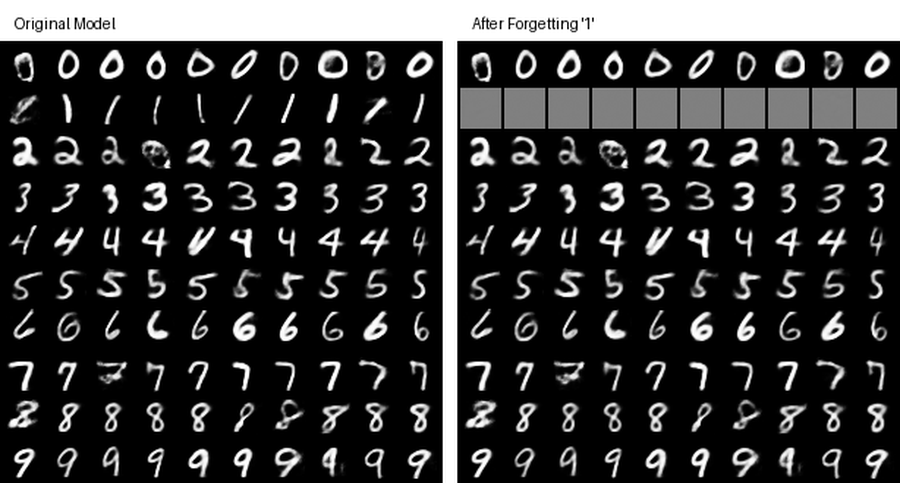

In [ ]:
gdrive_project_folder = "/content/drive/MyDrive/Colab_Selective_Amnesia"
amnesia_output_folder = os.path.join(gdrive_project_folder, "cvae_mnist_amnesia_output")
image_path = os.path.join(amnesia_output_folder, "logs", "final_amnesia_comparison.png")

print(f"Loading image from: {image_path}")

if not os.path.exists(image_path):
    print("ERROR: Image file not found. Please ensure Step 3 completed successfully.")
else:
    try:

        img = Image.open(image_path)

        desired_width = 900
        width_percent = (desired_width / float(img.size[0]))
        desired_height = int((float(img.size[1]) * float(width_percent)))

        # Resize the image
        img_resized = img.resize((desired_width, desired_height), Image.Resampling.LANCZOS)

        display(img_resized)

    except Exception as e:
        print(f"An error occurred while trying to display the image: {e}")

# 🧪 Classifier Evaluation

## train a classifier on the MNIST dataset

### Configuration

In [ ]:
gdrive_project_folder = "/content/drive/MyDrive/Colab_Selective_Amnesia"

classifier_output_folder = os.path.join(gdrive_project_folder, "classifier_output")
os.makedirs(classifier_output_folder, exist_ok=True)

classifier_config = SimpleNamespace(
    data_path="./dataset",
    batch_size=64,
    test_batch_size=1000,
    lr=1e-4,
    n_epochs=20,
    log_interval=100,

    ckpt_path=os.path.join(classifier_output_folder, "mnist_classifier.pt"),
)

### Classifier Model Definition

In [ ]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.bn1 = nn.BatchNorm2d(10)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.bn2 = nn.BatchNorm2d(20)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.bn1(self.conv1(x)), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.bn2(self.conv2(x))), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

### Training and Testing Functions

In [ ]:
def train(epoch, model, device, train_loader, optimizer, config):
    model.train()
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{config.n_epochs} [Training]")
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % config.log_interval == 0:
            pbar.set_postfix(loss=loss.item())

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    logging.info(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)\n')

### Main Execution

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logging.info(f"Using device: {device}")

# Data Loaders
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(classifier_config.data_path, train=True, download=True,
                               transform=torchvision.transforms.ToTensor()),
    batch_size=classifier_config.batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(classifier_config.data_path, train=False, download=True,
                               transform=torchvision.transforms.ToTensor()),
    batch_size=classifier_config.test_batch_size, shuffle=True)

# Initialize model and optimizer
net = Classifier().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=classifier_config.lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

logging.info("Starting classifier training...")
for epoch in range(1, classifier_config.n_epochs + 1):
    train(epoch, net, device, train_loader, optimizer, classifier_config)
    test(net, device, test_loader)
    scheduler.step()

# Save final trained classifier
torch.save(net.state_dict(), classifier_config.ckpt_path)
logging.info(f"Classifier training complete. Model saved to {classifier_config.ckpt_path}")

INFO - 2025-08-03 09:43:30,683 - Using device: cuda
INFO - 2025-08-03 09:43:30,772 - Starting classifier training...


Epoch 1/20 [Training]:   0%|          | 0/938 [00:00<?, ?it/s]

INFO - 2025-08-03 09:43:43,520 - 
Test set: Average loss: 0.3813, Accuracy: 9263/10000 (92.63%)



Epoch 2/20 [Training]:   0%|          | 0/938 [00:00<?, ?it/s]

INFO - 2025-08-03 09:43:55,277 - 
Test set: Average loss: 0.1931, Accuracy: 9516/10000 (95.16%)



Epoch 3/20 [Training]:   0%|          | 0/938 [00:00<?, ?it/s]

INFO - 2025-08-03 09:44:07,001 - 
Test set: Average loss: 0.1367, Accuracy: 9612/10000 (96.12%)



Epoch 4/20 [Training]:   0%|          | 0/938 [00:00<?, ?it/s]

INFO - 2025-08-03 09:44:18,743 - 
Test set: Average loss: 0.1114, Accuracy: 9677/10000 (96.77%)



Epoch 5/20 [Training]:   0%|          | 0/938 [00:00<?, ?it/s]

INFO - 2025-08-03 09:44:29,903 - 
Test set: Average loss: 0.0957, Accuracy: 9711/10000 (97.11%)



Epoch 6/20 [Training]:   0%|          | 0/938 [00:00<?, ?it/s]

INFO - 2025-08-03 09:44:41,332 - 
Test set: Average loss: 0.0941, Accuracy: 9716/10000 (97.16%)



Epoch 7/20 [Training]:   0%|          | 0/938 [00:00<?, ?it/s]

INFO - 2025-08-03 09:44:52,954 - 
Test set: Average loss: 0.0927, Accuracy: 9714/10000 (97.14%)



Epoch 8/20 [Training]:   0%|          | 0/938 [00:00<?, ?it/s]

INFO - 2025-08-03 09:45:04,706 - 
Test set: Average loss: 0.0921, Accuracy: 9723/10000 (97.23%)



Epoch 9/20 [Training]:   0%|          | 0/938 [00:00<?, ?it/s]

INFO - 2025-08-03 09:45:16,423 - 
Test set: Average loss: 0.0903, Accuracy: 9722/10000 (97.22%)



Epoch 10/20 [Training]:   0%|          | 0/938 [00:00<?, ?it/s]

INFO - 2025-08-03 09:45:28,132 - 
Test set: Average loss: 0.0892, Accuracy: 9725/10000 (97.25%)



Epoch 11/20 [Training]:   0%|          | 0/938 [00:00<?, ?it/s]

INFO - 2025-08-03 09:45:39,868 - 
Test set: Average loss: 0.0889, Accuracy: 9722/10000 (97.22%)



Epoch 12/20 [Training]:   0%|          | 0/938 [00:00<?, ?it/s]

INFO - 2025-08-03 09:45:51,737 - 
Test set: Average loss: 0.0891, Accuracy: 9725/10000 (97.25%)



Epoch 13/20 [Training]:   0%|          | 0/938 [00:00<?, ?it/s]

INFO - 2025-08-03 09:46:03,016 - 
Test set: Average loss: 0.0889, Accuracy: 9729/10000 (97.29%)



Epoch 14/20 [Training]:   0%|          | 0/938 [00:00<?, ?it/s]

INFO - 2025-08-03 09:46:14,288 - 
Test set: Average loss: 0.0887, Accuracy: 9724/10000 (97.24%)



Epoch 15/20 [Training]:   0%|          | 0/938 [00:00<?, ?it/s]

INFO - 2025-08-03 09:46:25,909 - 
Test set: Average loss: 0.0887, Accuracy: 9728/10000 (97.28%)



Epoch 16/20 [Training]:   0%|          | 0/938 [00:00<?, ?it/s]

INFO - 2025-08-03 09:46:37,647 - 
Test set: Average loss: 0.0886, Accuracy: 9722/10000 (97.22%)



Epoch 17/20 [Training]:   0%|          | 0/938 [00:00<?, ?it/s]

INFO - 2025-08-03 09:46:49,359 - 
Test set: Average loss: 0.0885, Accuracy: 9728/10000 (97.28%)



Epoch 18/20 [Training]:   0%|          | 0/938 [00:00<?, ?it/s]

INFO - 2025-08-03 09:47:01,097 - 
Test set: Average loss: 0.0886, Accuracy: 9727/10000 (97.27%)



Epoch 19/20 [Training]:   0%|          | 0/938 [00:00<?, ?it/s]

INFO - 2025-08-03 09:47:12,933 - 
Test set: Average loss: 0.0890, Accuracy: 9727/10000 (97.27%)



Epoch 20/20 [Training]:   0%|          | 0/938 [00:00<?, ?it/s]

INFO - 2025-08-03 09:47:24,863 - 
Test set: Average loss: 0.0886, Accuracy: 9727/10000 (97.27%)

INFO - 2025-08-03 09:47:24,872 - Classifier training complete. Model saved to /content/drive/MyDrive/Colab_Selective_Amnesia/classifier_output/mnist_classifier.pt


## Generate Samples for Evaluation

### Configuration

In [ ]:
gdrive_project_folder = "/content/drive/MyDrive/Colab_Selective_Amnesia"
original_output_folder = os.path.join(gdrive_project_folder, "cvae_mnist_output")
amnesia_output_folder = os.path.join(gdrive_project_folder, "cvae_mnist_amnesia_output")

gen_config = SimpleNamespace(

    original_vae_ckpt=os.path.join(original_output_folder, "checkpoints/cvae_mnist_final.pt"),
    amnesia_vae_ckpt=os.path.join(amnesia_output_folder, "checkpoints/amnesia_model_final.pt"),

    n_samples=1000,
    batch_size=1000,
    label_to_generate=1, # The digit we trained the model to forget

    original_samples_dir=os.path.join(original_output_folder, "generated_samples"),
    amnesia_samples_dir=os.path.join(amnesia_output_folder, "generated_samples"),
)

### Helper Function

In [ ]:
def generate_and_save(model, config, save_dir, device):
    """Generates samples and saves them"""
    os.makedirs(save_dir, exist_ok=True)
    model.eval()
    num_generated = 0
    with torch.no_grad():
        pbar = tqdm(range(config.n_samples // config.batch_size), desc=f"Generating in {os.path.basename(save_dir)}")
        for _ in pbar:
            z = torch.randn((config.batch_size, model.fc31.out_features)).to(device)
            c = F.one_hot(torch.full((config.batch_size,), config.label_to_generate), 10).float().to(device)
            samples = model.decoder(z, c).view(-1, 1, 28, 28)
            for sample in samples:
                save_path = os.path.join(save_dir, f'{num_generated}.png')
                save_image(sample, save_path)
                num_generated += 1
    print(f"Successfully saved {num_generated} images to: {save_dir}\n")

### Main Execution

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}\n")

try:
    print("--- Loading Original VAE ---")
    orig_checkpoint = torch.load(gen_config.original_vae_ckpt, map_location=device, weights_only=False)
    config_from_ckpt = orig_checkpoint['config']
    original_vae = OneHotCVAE(config_from_ckpt.x_dim, config_from_ckpt.h_dim1, config_from_ckpt.h_dim2, config_from_ckpt.z_dim).to(device)
    original_vae.load_state_dict(orig_checkpoint['model_state_dict'])
    generate_and_save(original_vae, gen_config, gen_config.original_samples_dir, device)

    print("--- Loading Amnesiac VAE ---")
    amnesia_checkpoint = torch.load(gen_config.amnesia_vae_ckpt, map_location=device, weights_only=False)
    config_from_ckpt = amnesia_checkpoint['config']
    amnesia_vae = OneHotCVAE(config_from_ckpt.x_dim, config_from_ckpt.h_dim1, config_from_ckpt.h_dim2, config_from_ckpt.z_dim).to(device)
    amnesia_vae.load_state_dict(amnesia_checkpoint['model_state_dict'])
    generate_and_save(amnesia_vae, gen_config, gen_config.amnesia_samples_dir, device)

    print("All samples generated successfully.")

except FileNotFoundError as e:
    print(f"ERROR: Could not find a required model file. Please ensure all previous steps ran successfully. Details: {e}")

Using device: cuda

--- Loading Original VAE ---


Generating in generated_samples:   0%|          | 0/1 [00:00<?, ?it/s]

Successfully saved 1000 images to: /content/drive/MyDrive/Colab_Selective_Amnesia/cvae_mnist_output/generated_samples

--- Loading Amnesiac VAE ---


Generating in generated_samples:   0%|          | 0/1 [00:00<?, ?it/s]

Successfully saved 1000 images to: /content/drive/MyDrive/Colab_Selective_Amnesia/cvae_mnist_amnesia_output/generated_samples

All samples generated successfully.


## Evaluate with the classifier

### Configuration

In [ ]:
gdrive_project_folder = "/content/drive/MyDrive/Colab_Selective_Amnesia"
original_output_folder = os.path.join(gdrive_project_folder, "cvae_mnist_output")
amnesia_output_folder = os.path.join(gdrive_project_folder, "cvae_mnist_amnesia_output")
classifier_output_folder = os.path.join(gdrive_project_folder, "classifier_output")

eval_config = SimpleNamespace(

    classifier_ckpt=os.path.join(classifier_output_folder, "mnist_classifier.pt"),

    original_samples_dir=os.path.join(original_output_folder, "generated_samples"),
    amnesia_samples_dir=os.path.join(amnesia_output_folder, "generated_samples"),

    label_to_evaluate=1, # The label we tried to forget
    batch_size=256,
)

### Evaluation Function

In [ ]:
def evaluate_from_loader(classifier, loader, config, device):
    """Evaluates images from a DataLoader using the classifier."""

    classifier.eval()
    all_probs = []
    with torch.no_grad():
        for data in tqdm(loader, desc="Evaluating with Classifier"):
            log_probs = classifier(data.to(device))
            probs = torch.exp(log_probs)
            all_probs.append(probs.cpu())
    all_probs = torch.cat(all_probs, dim=0)
    prob_forgotten = all_probs[:, config.label_to_evaluate].mean().item()
    entropy = -torch.sum(all_probs * torch.log(all_probs + 1e-9), dim=1).mean().item()
    return prob_forgotten, entropy

In [ ]:
class ImagePathDataset(torch.utils.data.Dataset):
    """Custom Dataset for loading images from a folder."""
    def __init__(self, img_folder, transforms=None):
        self.transforms = transforms
        path = pathlib.Path(img_folder)
        self.files = sorted([file for ext in {'png'} for file in path.glob(f'*.{ext}')])
        if len(self.files) == 0:
            raise FileNotFoundError(f"No images found in {img_folder}. Please ensure samples were generated correctly in the previous step.")
    def __len__(self):
        return len(self.files)
    def __getitem__(self, i):
        path = self.files[i]
        img = Image.open(path).convert('L')
        if self.transforms:
            img = self.transforms(img)
        return img

### Main Execution

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
try:
    # Load the trained classifier
    classifier = Classifier().to(device)
    classifier.load_state_dict(torch.load(eval_config.classifier_ckpt, map_location=device))
    print("Classifier model loaded successfully.\n")

    # Create DataLoaders from the pre-saved sample folders
    original_dataset = ImagePathDataset(eval_config.original_samples_dir, transforms=transforms.ToTensor())
    amnesia_dataset = ImagePathDataset(eval_config.amnesia_samples_dir, transforms=transforms.ToTensor())
    original_loader = DataLoader(original_dataset, batch_size=eval_config.batch_size)
    amnesia_loader = DataLoader(amnesia_dataset, batch_size=eval_config.batch_size)
    print(f"Found {len(original_dataset)} samples for the original model.")
    print(f"Found {len(amnesia_dataset)} samples for the amnesiac model.\n")

    # Run evaluation on the loaded samples
    print(f"--- Evaluating Forgetting for Digit '{eval_config.label_to_evaluate}' ---")
    prob_orig, entropy_orig = evaluate_from_loader(classifier, original_loader, eval_config, device)
    print("\nOriginal Model (Before Forgetting):")
    print(f"  - Avg. Probability of seeing a '{eval_config.label_to_evaluate}': {prob_orig:.4f} (Expected: High, close to 1.0)")
    print(f"  - Classifier Entropy: {entropy_orig:.4f} (Expected: Low)")

    prob_amnesia, entropy_amnesia = evaluate_from_loader(classifier, amnesia_loader, eval_config, device)
    print("\nAmnesiac Model (After Forgetting):")
    print(f"  - Avg. Probability of seeing a '{eval_config.label_to_evaluate}': {prob_amnesia:.4f} (Expected: Low, close to 0.1)")
    print(f"  - Classifier Entropy: {entropy_amnesia:.4f} (Expected: High, close to log(10) ≈ 2.3)")

except FileNotFoundError as e:
    print(f"ERROR: Could not find a required model or data file. Please ensure all previous steps ran successfully. Details: {e}")

Classifier model loaded successfully.

Found 1000 samples for the original model.
Found 1000 samples for the amnesiac model.

--- Evaluating Forgetting for Digit '1' ---


Evaluating with Classifier:   0%|          | 0/4 [00:00<?, ?it/s]


Original Model (Before Forgetting):
  - Avg. Probability of seeing a '1': 0.9704 (Expected: High, close to 1.0)
  - Classifier Entropy: 0.0999 (Expected: Low)


Evaluating with Classifier:   0%|          | 0/4 [00:00<?, ?it/s]


Amnesiac Model (After Forgetting):
  - Avg. Probability of seeing a '1': 0.2045 (Expected: Low, close to 0.1)
  - Classifier Entropy: 2.2175 (Expected: High, close to log(10) ≈ 2.3)
